In [31]:
#  Import all relevent libraries
import numpy as np
import pandas as pd
import time
import os
import tensorflow as tf
import scipy.optimize as spo
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow.keras.models import load_model
import ipywidgets as widgets
from IPython.display import display
from scipy.interpolate import griddata


In [32]:
# Problem / numerical params
tf.random.set_seed(42); np.random.seed(42)
Re_min, Re_max = 5e1, 3e2   # Trainning range of Re
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0
D_default = 10  # Number of hidden layes
N_default = 80  # Neurons in each hidden layer
Nx_cells = 100  # Colocation points = Nx_cells*Ny_cells
Ny_cells = 100
N_b_per_side = 1000 # Boundary points 


In [33]:
# PurePINNs Architecture
class PurePINN(tf.keras.Model):
    def __init__(self,
                 num_hidden_layers=D_default,
                 num_neurons_per_layer=N_default,
                 include_pressure=True,
                 activation='tanh',
                 kernel_regularizer=tf.keras.regularizers.L2(1e-8),
                 x_mean=0.5, x_scale=0.5,
                 y_mean=0.5, y_scale=0.5,
                 re_mean=np.log(500.0), re_scale=1.0,
                 use_log_re=True,
                 **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.num_neurons_per_layer = num_neurons_per_layer
        self.include_pressure = include_pressure
        self.use_log_re = use_log_re

        # Normalization constants
        self.x_mean = tf.constant(x_mean, dtype=tf.float32)
        self.x_scale = tf.constant(x_scale, dtype=tf.float32)
        self.y_mean = tf.constant(y_mean, dtype=tf.float32)
        self.y_scale = tf.constant(y_scale, dtype=tf.float32)
        self.re_mean = tf.constant(re_mean, dtype=tf.float32)
        self.re_scale = tf.constant(re_scale, dtype=tf.float32)

        # Input normalization layer
        self.input_norm = tf.keras.layers.Lambda(self._normalize_inputs, name='input_norm')

        # Hidden layers
        hidden = []
        for i in range(num_hidden_layers):
            hidden.append(tf.keras.layers.Dense(num_neurons_per_layer,
                                                activation=activation,
                                                kernel_initializer='glorot_normal',
                                                kernel_regularizer=kernel_regularizer,
                                                name=f'dense_{i}'))
            hidden.append(tf.keras.layers.LayerNormalization(name=f'ln_{i}'))
        self.hidden_seq = tf.keras.Sequential(hidden, name='hidden_seq')

        # Output layers
        self.u_out = tf.keras.layers.Dense(1, activation=None, name='u_out')
        self.v_out = tf.keras.layers.Dense(1, activation=None, name='v_out')
        if self.include_pressure:
            self.p_out = tf.keras.layers.Dense(1, activation=None, name='p_out')
        else:
            self.p_out = None

    def _normalize_inputs(self, X):
        x = X[:, 0:1]
        y = X[:, 1:2]
        re = X[:, 2:3]

        x_n = (x - self.x_mean) / (self.x_scale + 1e-8)
        y_n = (y - self.y_mean) / (self.y_scale + 1e-8)
        if self.use_log_re:
            re_n = (tf.math.log(tf.maximum(re, 1e-8)) - self.re_mean) / (self.re_scale + 1e-8)
        else:
            re_n = (re - tf.exp(self.re_mean)) / (self.re_scale + 1e-8)

        return tf.concat([x_n, y_n, re_n], axis=1)

    def call(self, inputs, training=False):
        xn = self.input_norm(inputs)
        h = self.hidden_seq(xn, training=training)
        u = self.u_out(h)
        v = self.v_out(h)
        if self.include_pressure:
            p = self.p_out(h)
        else:
            p = tf.zeros_like(u)
        return u, v, p


In [34]:
# Load the trainned model
PurePINN_model = tf.keras.models.load_model('LIDRePurePINNs.keras', custom_objects={'PurePINN': PurePINN})

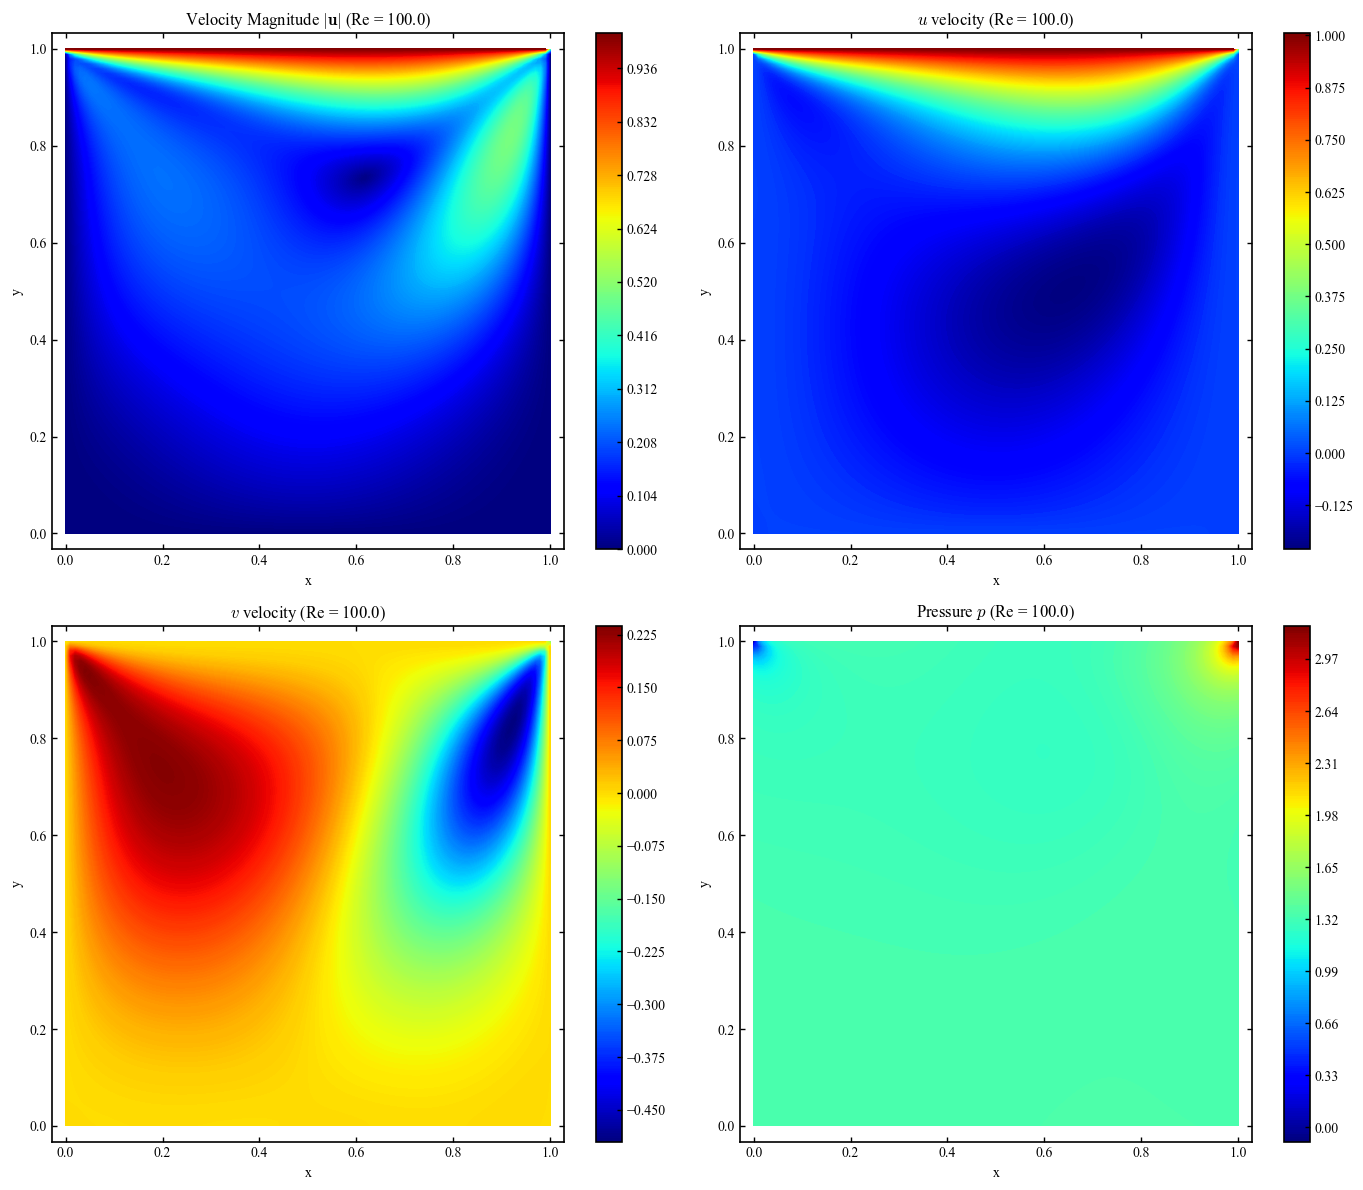

In [35]:
# User interface: Enter Reynolds number
Re_plot = float(input("Enter Reynolds number (Re): "))

# Grid for plotting
Nx, Ny = 101, 101
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)

Re_val = np.full_like(X, Re_plot)

# Stack grid points into (x, y, Re) tensor
X_input = np.stack(
    [X.flatten(), Y.flatten(), Re_val.flatten()],
    axis=1
)
X_tf = tf.convert_to_tensor(X_input, dtype=tf.float32)


# Evaluate model outputs (u, v, p)
u_pred, v_pred, p_pred = PurePINN_model(X_tf)

u_pred = u_pred.numpy().reshape(Ny, Nx)
v_pred = v_pred.numpy().reshape(Ny, Nx)
p_pred = p_pred.numpy().reshape(Ny, Nx)

# Velocity magnitude
vel_mag = np.sqrt(u_pred**2 + v_pred**2)

# Combined contour plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Velocity magnitude
c0 = axes[0, 0].contourf(X, Y, vel_mag, levels=300, cmap='jet')
fig.colorbar(c0, ax=axes[0, 0])
axes[0, 0].set_title(rf"Velocity Magnitude $|\mathbf{{u}}|$ (Re = {Re_plot})")
axes[0, 0].set_xlabel("x")
axes[0, 0].set_ylabel("y")
axes[0, 0].axis("equal")

# u-velocity
c1 = axes[0, 1].contourf(X, Y, u_pred, levels=300, cmap='jet')
fig.colorbar(c1, ax=axes[0, 1])
axes[0, 1].set_title(rf"$u$ velocity (Re = {Re_plot})")
axes[0, 1].set_xlabel("x")
axes[0, 1].set_ylabel("y")
axes[0, 1].axis("equal")

# v-velocity
c2 = axes[1, 0].contourf(X, Y, v_pred, levels=300, cmap='jet')
fig.colorbar(c2, ax=axes[1, 0])
axes[1, 0].set_title(rf"$v$ velocity (Re = {Re_plot})")
axes[1, 0].set_xlabel("x")
axes[1, 0].set_ylabel("y")
axes[1, 0].axis("equal")

# Pressure
c3 = axes[1, 1].contourf(X, Y, p_pred, levels=300, cmap='jet')
fig.colorbar(c3, ax=axes[1, 1])
axes[1, 1].set_title(rf"Pressure $p$ (Re = {Re_plot})")
axes[1, 1].set_xlabel("x")
axes[1, 1].set_ylabel("y")
axes[1, 1].axis("equal")

plt.tight_layout()
plt.show()


In [ ]:


# Load the CFD data
data_file = fr"CFD DATA\DataRe{int(Re_plot)}.csv"
cfd_data = pd.read_csv(data_file)

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

# Extract input and output columns
x_data = cfd_data['x'].values.reshape(-1, 1)
y_data = cfd_data['y'].values.reshape(-1, 1)
inputs = np.hstack((x_data, y_data))

u_data = cfd_data['u'].values.reshape(-1, 1)
v_data = cfd_data['v'].values.reshape(-1, 1)
p_data = cfd_data['p'].values.reshape(-1, 1)
outputs = np.hstack((u_data, v_data, p_data))

# Define grid range
xmin, xmax = x_data.min(), x_data.max()
ymin, ymax = y_data.min(), y_data.max()

# Create a grid for contour plotting
nx, ny = 101, 101
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# Interpolate scattered data onto the grid
U_grid = griddata((x_data.flatten(), y_data.flatten()), u_data.flatten(), (X, Y), method='cubic')
V_grid = griddata((x_data.flatten(), y_data.flatten()), v_data.flatten(), (X, Y), method='cubic')
P_grid = griddata((x_data.flatten(), y_data.flatten()), p_data.flatten(), (X, Y), method='cubic')


# Choose Reynolds number for evaluation (can be fixed or changed)

Nx, Ny = nx, ny   # grid resolution for plotting
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)

Ra_val = np.full_like(X, Re_plot)

# Stack grid points into (x, y, Ra) tensor
X_input = np.stack([X.flatten(), Y.flatten(), Ra_val.flatten()], axis=1)
X_tf = tf.convert_to_tensor(X_input, dtype=tf.float32)


# Evaluate model outputs (u, v, theta, p)

u_pred, v_pred, p_pred = PurePINN_model(X_tf)
u_pred = u_pred.numpy().reshape(Ny, Nx)
v_pred = v_pred.numpy().reshape(Ny, Nx)
p_pred = p_pred.numpy().reshape(Ny, Nx)
p_pred = p_pred - np.mean(p_pred)

from sklearn.metrics import mean_squared_error, r2_score

def valid_mask(a, b):
    """Return mask where both arrays are valid (non-NaN)."""
    return ~np.isnan(a.flatten()) & ~np.isnan(b.flatten())

# U field
mask_u = valid_mask(U_grid, u_pred)
U_true = U_grid.flatten()[mask_u]
U_hat = u_pred.flatten()[mask_u]

MSE_U = mean_squared_error(U_true, U_hat)
R2_U  = r2_score(U_true, U_hat)

# V field
mask_v = valid_mask(V_grid, v_pred)
V_true = V_grid.flatten()[mask_v]
V_hat  = v_pred.flatten()[mask_v]

MSE_V = mean_squared_error(V_true, V_hat)
R2_V  = r2_score(V_true, V_hat)

#  P field 
mask_p = valid_mask(P_grid, p_pred)
P_true = P_grid.flatten()[mask_p]
P_hat  = p_pred.flatten()[mask_p]

MSE_P = mean_squared_error(P_true, P_hat)

# Mean-correct pressure for R²
P_true_zero = P_true - np.mean(P_true)
P_hat_zero  = P_hat  - np.mean(P_hat)

R2_P = r2_score(P_true_zero, P_hat_zero)

# Print results
print(" MODEL PERFORMANCE ")
print(f"MSE (U): {MSE_U:.6e}")
print(f"R²  (U): {R2_U:.6f}\n")

print(f"MSE (V): {MSE_V:.6e}")
print(f"R²  (V): {R2_V:.6f}\n")

print(f"MSE (P): {MSE_P:.6e}")
print(f"Mean-Corrected R²  (P): {R2_P:.6f}")



 MODEL PERFORMANCE 
MSE (U): 1.256020e-04
R²  (U): 0.997492

MSE (V): 1.278657e-04
R²  (V): 0.994282

MSE (P): 1.028362e-03
Mean-Corrected R²  (P): 0.923384


In [ ]:


# Load the CFD data
data_file = fr"CFD DATA\DataRe{int(Re_plot)}.csv"
cfd_data = pd.read_csv(data_file)

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

# Extract input and output columns
x_data = cfd_data['x'].values.reshape(-1, 1)
y_data = cfd_data['y'].values.reshape(-1, 1)
inputs = np.hstack((x_data, y_data))

u_data = cfd_data['u'].values.reshape(-1, 1)
v_data = cfd_data['v'].values.reshape(-1, 1)
p_data = cfd_data['p'].values.reshape(-1, 1)
outputs = np.hstack((u_data, v_data, p_data))


xmin, xmax = x_data.min(), x_data.max()
ymin, ymax = y_data.min(), y_data.max()

# Create a grid for contour plotting
nx, ny = 101, 101
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# # Interpolate scattered data onto the grid
U_grid = griddata((x_data.flatten(), y_data.flatten()), u_data.flatten(), (X, Y), method='cubic')
V_grid = griddata((x_data.flatten(), y_data.flatten()), v_data.flatten(), (X, Y), method='cubic')
P_grid = griddata((x_data.flatten(), y_data.flatten()), p_data.flatten(), (X, Y), method='cubic')


# Choose reynolds number for evaluation (can be fixed or changed)
Nx, Ny = nx, ny   # grid resolution for plotting
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)


Ra_val = np.full_like(X, Re_plot)

# Stack grid points into (x, y, Ra) tensor
X_input = np.stack([X.flatten(), Y.flatten(), Ra_val.flatten()], axis=1)
X_tf = tf.convert_to_tensor(X_input, dtype=tf.float32)


# Evaluate model outputs (u, v, theta, p)
u_pred, v_pred, p_pred = PurePINN_model(X_tf)
u_pred = u_pred.numpy().reshape(Ny, Nx)
v_pred = v_pred.numpy().reshape(Ny, Nx)
p_pred = p_pred.numpy().reshape(Ny, Nx)
p_pred = p_pred - np.mean(p_pred)


# Compute velocity magnitude for visualization
vel_mag = np.sqrt(u_pred**2 + v_pred**2)



In [38]:


def plot_actual_predicted_error(
    X, Y, actual, predicted, title_actual, title_predicted,title_error,
    axis_fontsize=16,
    tick_fontsize=14,
    title_fontsize=18,
    cbar_fontsize=14,
    save_path=None 
):
    # Use publication-style parameters
    plt.rcParams.update({
        "font.family": "serif",
        "axes.linewidth": 1.2,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.top": True,
        "ytick.right": True,
        "xtick.major.width": 1.0,
        "ytick.major.width": 1.0,
        "xtick.minor.width": 0.8,
        "ytick.minor.width": 0.8,
    })

    fig, axs = plt.subplots(1, 3, figsize=(15, 4.5), constrained_layout=True)

    # Compute absolute error
    error = np.abs(actual - predicted)

    # Common vmin/vmax for actual & predicted
    vmin = min(np.nanmin(actual), np.nanmin(predicted))
    vmax = max(np.nanmax(actual), np.nanmax(predicted))

    # Actual
    contour_actual = axs[0].contourf(X, Y, actual, levels=300, cmap="jet", vmin=vmin, vmax=vmax)
    axs[0].set_title(title_actual, fontsize=title_fontsize)
    axs[0].set_xlabel("x [m]", fontsize=axis_fontsize)
    axs[0].set_ylabel("y [m]", fontsize=axis_fontsize)
    axs[0].tick_params(axis="both", labelsize=tick_fontsize)
    axs[0].text(0.5, -0.20, "(a)", transform=axs[0].transAxes,
                ha="center", va="center", fontsize=title_fontsize)

    # Predicted
    contour_predicted = axs[1].contourf(X, Y, predicted, levels=300, cmap="jet", vmin=vmin, vmax=vmax)
    axs[1].set_title(title_predicted, fontsize=title_fontsize)
    axs[1].set_xlabel("x [m]", fontsize=axis_fontsize)
    axs[1].set_ylabel("y [m]", fontsize=axis_fontsize)
    axs[1].tick_params(axis="both", labelsize=tick_fontsize)
    axs[1].text(0.5, -0.20, "(b)", transform=axs[1].transAxes,
                ha="center", va="center", fontsize=title_fontsize)

    # Error
    contour_error = axs[2].contourf(X, Y, error, levels=300, cmap="jet")
    axs[2].set_title(title_error, fontsize=title_fontsize)
    axs[2].set_xlabel("x [m]", fontsize=axis_fontsize)
    axs[2].set_ylabel("y [m]", fontsize=axis_fontsize)
    axs[2].tick_params(axis="both", labelsize=tick_fontsize)
    axs[2].text(0.5, -0.20, "(c)", transform=axs[2].transAxes,
                ha="center", va="center", fontsize=title_fontsize)

    # Shared colorbar for actual & predicted
    cbar = fig.colorbar(contour_actual, ax=axs[0:2], shrink=0.9, pad=0.02, aspect=30)
    cbar.set_label("Value", fontsize=cbar_fontsize)
    cbar.ax.tick_params(labelsize=tick_fontsize)

    # Separate colorbar for error
    cbar_error = fig.colorbar(contour_error, ax=axs[2], shrink=0.9, pad=0.02, aspect=30)
    cbar_error.set_label("Error", fontsize=cbar_fontsize)
    cbar_error.ax.tick_params(labelsize=tick_fontsize)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


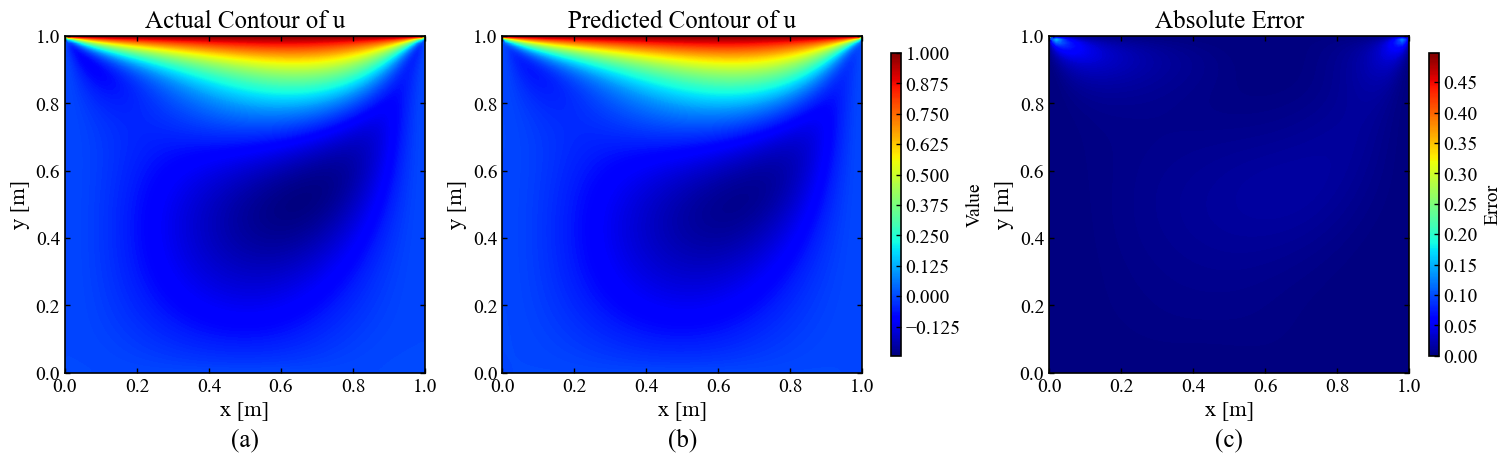

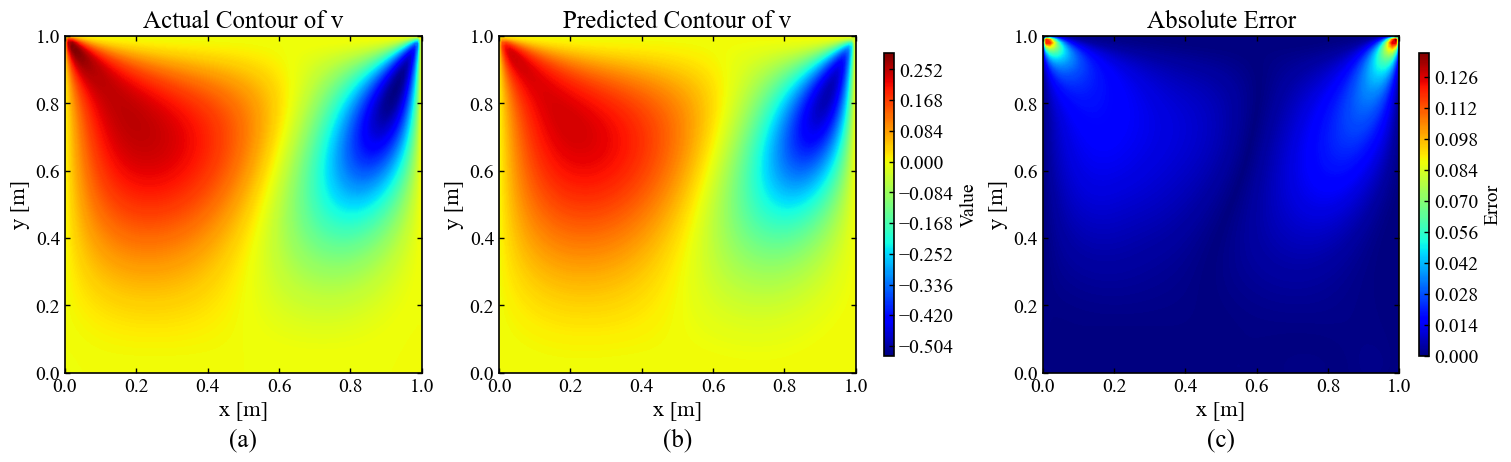

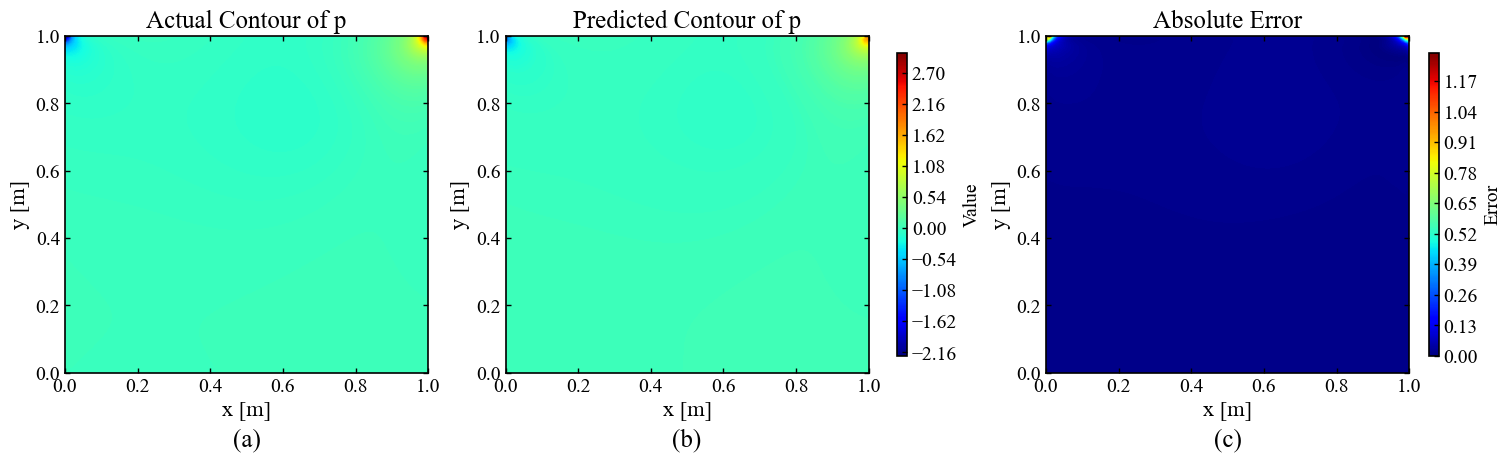

In [39]:
# Plot actual and predicted for u
plot_actual_predicted_error(X, Y, U_grid, u_pred, 'Actual Contour of u', 'Predicted Contour of u', 'Absolute Error')

# Plot actual and predicted for v
plot_actual_predicted_error(X, Y, V_grid, v_pred, 'Actual Contour of v', 'Predicted Contour of v','Absolute Error')

# Plot actual and predicted for p
plot_actual_predicted_error(X, Y, P_grid, p_pred, 'Actual Contour of p', 'Predicted Contour of p','Absolute Error')





In [40]:
# POF STYLE
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
})


def plot_profiles_multiple_locations_single_plot(
    X, Y, U_grid, V_grid, u_pred, v_pred,
    locations=(0.3, 0.5,0.8),
    font_size=16,
    label_fs=None,
    tick_fs=None,
    legend_fs=None,
    title_fs=None,
    error_stride=5,
    legend_x=0.98,
    legend_y=0.98
):

    # Font fallbacks 
    label_fs  = label_fs  or font_size
    tick_fs   = tick_fs   or font_size * 0.8
    legend_fs = legend_fs or font_size * 0.6
    title_fs  = title_fs  or font_size

    xmin, xmax = 0, 1
    nx, ny = U_grid.shape
    x_lin = np.linspace(xmin, xmax, nx)
    y_lin = np.linspace(xmin, xmax, ny)

    fig, ax_vx = plt.subplots(figsize=(7.2, 7.0))

    # Error model
    E = 0.05

    colors     = ['tab:red', 'tab:blue', 'tab:green']
    markers    = ['o', 's', '^']
    linestyles = ['-', '--', '-.']  

  
    # v(x) at y locations
   
    for i, y0 in enumerate(locations):
        yi = np.abs(y_lin - y0).argmin()
        col, mk, ls = colors[i], markers[i], linestyles[i]

        v_act = V_grid[yi, :]
        v_prd = v_pred[yi, :]
        v_err = np.abs(E * v_act)

        # CFD  markers
        ax_vx.plot(
            x_lin, v_act,
            linestyle='none',
            marker=mk, markersize=3,
            markerfacecolor=col,
            markeredgecolor='k',
            label=rf'$v$ CFD, $y={y_lin[yi]:.1f}$'
        )

        # PINNs  different line styles
        ax_vx.plot(
            x_lin, v_prd,
            linestyle=ls,
            lw=0.8,
            color=col,
            label=rf'$v$ PINNs, $y={y_lin[yi]:.1f}$'
        )

        step = slice(0, len(x_lin), error_stride)
        ax_vx.errorbar(
            x_lin[step], v_prd[step],
            yerr=v_err[step],
            fmt='none',
            ecolor=col,
            capsize=3
        )

    ax_vx.set_xlabel(r'$x$', fontsize=label_fs)
    ax_vx.set_ylabel(r'$v$', fontsize=label_fs)
    ax_vx.set_xlim(0, 1)
    ax_vx.set_ylim(-1.0, 1.0)
    ax_vx.tick_params(labelsize=tick_fs)


    # Right axis: y

    ax_y = ax_vx.twinx()
    ax_y.set_ylabel(r'$y$', fontsize=label_fs)
    ax_y.set_ylim(0, 1)
    ax_y.tick_params(labelsize=tick_fs)


    # Top axis: u(y) at x locations

    ax_u = ax_y.twiny()

    for i, x0 in enumerate(locations):
        xi = np.abs(x_lin - x0).argmin()
        col, mk, ls = colors[i], markers[i], linestyles[i]

        u_act = U_grid[:, xi]
        u_prd = u_pred[:, xi]
        u_err = np.abs(E * u_act)

        # CFD  markers
        ax_u.plot(
            u_act, y_lin,
            linestyle='none',
            marker=mk, markersize=3,
            markerfacecolor=col,
            markeredgecolor='k',
            label=rf'$u$ CFD, $x={x_lin[xi]:.1f}$'
        )

        # PINNs different line styles
        ax_u.plot(
            u_prd, y_lin,
            linestyle=ls,
            lw=0.8,
            color=col,
            label=rf'$u$ PINNs, $x={x_lin[xi]:.1f}$'
        )

        step = slice(0, len(y_lin), error_stride)
        ax_u.errorbar(
            u_prd[step], y_lin[step],
            xerr=u_err[step],
            fmt='none',
            ecolor=col,
            capsize=3
        )

    ax_u.set_xlabel(r'$u$', fontsize=label_fs)
    ax_u.set_xlim(-1.0, 1.0)
    ax_u.tick_params(labelsize=tick_fs)

 
    # Legend
    hv, lv = ax_vx.get_legend_handles_labels()
    hu, lu = ax_u.get_legend_handles_labels()

    ax_vx.legend(
        hv + hu,
        lv + lu,
        fontsize=legend_fs,
        loc='upper right',
        bbox_to_anchor=(legend_x, legend_y),
        frameon=False
    )

    plt.tight_layout()
    plt.show()


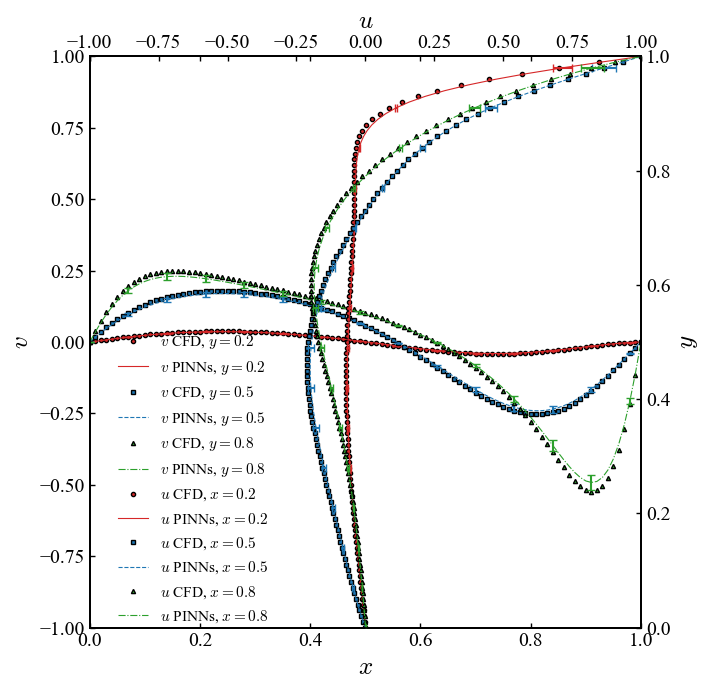

In [41]:
plot_profiles_multiple_locations_single_plot(
    X, Y,
    U_grid, V_grid,
    u_pred, v_pred,
    locations=(0.2, 0.5,0.8),
    font_size=16,
    label_fs=18,
    tick_fs=14,
    legend_fs=11,
    title_fs=16,
    error_stride=7,
    legend_x=0.35,
    legend_y=0.54
)


In [ ]:


# Load the CFD data
data_file = fr"CFD DATA\DataRe{int(Re_plot)}.csv"
cfd_data = pd.read_csv(data_file)

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

# Extract input and output columns
x_data = cfd_data['x'].values.reshape(-1, 1)
y_data = cfd_data['y'].values.reshape(-1, 1)
inputs = np.hstack((x_data, y_data))

u_data = cfd_data['u'].values.reshape(-1, 1)
v_data = cfd_data['v'].values.reshape(-1, 1)
p_data = cfd_data['p'].values.reshape(-1, 1)
outputs = np.hstack((u_data, v_data, p_data))

# Define grid range
xmin, xmax = x_data.min(), x_data.max()
ymin, ymax = y_data.min(), y_data.max()

# Create a grid for contour plotting
nx, ny = 1001, 1001
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# Interpolate scattered data onto the grid
U_grid = griddata((x_data.flatten(), y_data.flatten()), u_data.flatten(), (X, Y), method='cubic')
V_grid = griddata((x_data.flatten(), y_data.flatten()), v_data.flatten(), (X, Y), method='cubic')
P_grid = griddata((x_data.flatten(), y_data.flatten()), p_data.flatten(), (X, Y), method='cubic')


# Choose Reynolds number for evaluation (can be fixed or changed)

Nx, Ny = nx, ny   # grid resolution for plotting
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)

Ra_val = np.full_like(X, Re_plot)

# Stack grid points into (x, y, Ra) tensor
X_input = np.stack([X.flatten(), Y.flatten(), Ra_val.flatten()], axis=1)
X_tf = tf.convert_to_tensor(X_input, dtype=tf.float32)


# Evaluate model outputs (u, v, theta, p)

u_pred, v_pred, p_pred = PurePINN_model(X_tf)
u_pred = u_pred.numpy().reshape(Ny, Nx)
v_pred = v_pred.numpy().reshape(Ny, Nx)
p_pred = p_pred.numpy().reshape(Ny, Nx)
p_pred = p_pred - np.mean(p_pred)

from sklearn.metrics import mean_squared_error, r2_score

# Flatten all fields 
def valid_mask(a, b):
    """Return mask where both arrays are valid (non-NaN)."""
    return ~np.isnan(a.flatten()) & ~np.isnan(b.flatten())

#  U field 
mask_u = valid_mask(U_grid, u_pred)
U_true = U_grid.flatten()[mask_u]
U_hat = u_pred.flatten()[mask_u]

MSE_U = mean_squared_error(U_true, U_hat)
R2_U  = r2_score(U_true, U_hat)

#  V field 
mask_v = valid_mask(V_grid, v_pred)
V_true = V_grid.flatten()[mask_v]
V_hat  = v_pred.flatten()[mask_v]

MSE_V = mean_squared_error(V_true, V_hat)
R2_V  = r2_score(V_true, V_hat)

#  P field 
mask_p = valid_mask(P_grid, p_pred)
P_true = P_grid.flatten()[mask_p]
P_hat  = p_pred.flatten()[mask_p]

MSE_P = mean_squared_error(P_true, P_hat)

# Mean-correct pressure for R²
P_true_zero = P_true - np.mean(P_true)
P_hat_zero  = P_hat  - np.mean(P_hat)

R2_P = r2_score(P_true_zero, P_hat_zero)

# Print results
print(" MODEL PERFORMANCE ")
print(f"MSE (U): {MSE_U:.6e}")
print(f"R²  (U): {R2_U:.6f}\n")

print(f"MSE (V): {MSE_V:.6e}")
print(f"R²  (V): {R2_V:.6f}\n")

print(f"MSE (P): {MSE_P:.6e}")
print(f"Mean-Corrected R²  (P): {R2_P:.6f}")



 MODEL PERFORMANCE 
MSE (U): 1.056731e-04
R²  (U): 0.997715

MSE (V): 1.288675e-04
R²  (V): 0.994339

MSE (P): 6.388760e-04
Mean-Corrected R²  (P): 0.952222
